# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

   year  month  day gender  births
0  1969      1  1.0      F    4046
1  1969      1  1.0      M    4440
2  1969      1  2.0      F    4454
3  1969      1  2.0      M    4548
4  1969      1  3.0      F    4548


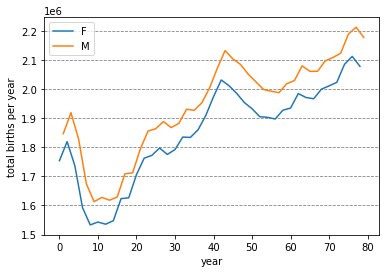

In [2]:
df = pd.read_csv("data/births.csv")
print(df.head())

custom = df.groupby(['year', 'gender']).agg({'births': ['sum']}).reset_index()

fig, ax = plt.subplots()

ax.plot(custom[custom['gender']=='F']['births'])
ax.plot(custom[custom['gender']=='M']['births'])
ax.set_xlabel('year')
ax.set_ylabel('total births per year')
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.legend(('F','M'))

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

In [3]:
# ref 1 http://chmullig.com/2012/06/births-by-day-of-year/
# ref 2 https://www.mathworks.com/help/signal/ug/significance-testing-for-periodic-component.html
# ref 3 https://www.toppr.com/guides/business-mathematics-and-statistics/time-series-analysis/components-of-time-series/
# ref 4 https://machinelearningmastery.com/visualize-time-series-residual-forecast-errors-with-python/

# The periodic component:
    # When observing and studying a variable over a period time, there are trends that can repeat over cyclical periods or seasons.

# The residual component:
    # "Forecast errors on time series regression problems are called residuals or residual errors" [ref 4]

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

In [4]:
df = df.dropna() 
df = df.reset_index(drop = True) 

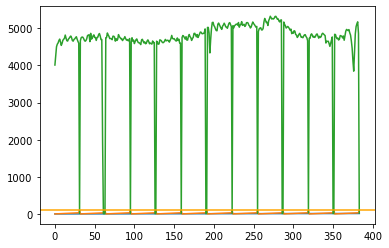

In [5]:
df['combined_date'] = pd.to_datetime(df[['year','month','day']],errors='coerce')
average = 100

fig, ax = plt.subplots()
x = df['combined_date']
custom = df.groupby(['month','day']).agg({'births': ['mean']}).reset_index()
y = custom.births
ax.plot(custom)
ax.axhline(y=average, color='orange')

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [6]:
import gzip
import numpy as np
import pandas as pd

In [7]:
with gzip.open('data/recipe.json.gz', 'r') as f:
    line = f.readline()
pd.read_json(line).shape

(2, 12)

In [8]:
# read the entire file into a Python array
with gzip.open('data/recipe.json.gz', 'r') as f:
    # Extract each line
    data = (line.strip().decode() for line in f)
    # Reformat so each line is the element of a list
    data_json = f"[{','.join(data)}]"
# read the result as a JSON
recipes = pd.read_json(data_json)

In [9]:
recipes.shape

(173278, 17)

In [10]:
recipes['description'].str.lower().str.contains("breakfast").sum()

3524

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [11]:
# ref : https://stackoverflow.com/questions/39050539/how-to-add-multiple-columns-to-pandas-dataframe-in-one-assignment

In [12]:
def recommend_ingredients(ingredients, df):
    for item in ingredients:
        df[ing] = df['ingredients'].str.lower().str.contains(item)
    for item in ingredients:
        df = df.loc[df[item] == True]
    return df.index

In [13]:
recommend_ingredients(["parsley", "paprika", "tarragon"], recipes)

NameError: name 'ing' is not defined

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [ ]:
movies_url = {
"movies_metadata": "1RLvh6rhzYiDDjPaudDgyS9LmqjbKH-wh",
"keywords": "1YLOIxb-EPC_7QpkmRqkq9E6j7iqmoEh3",
"ratings": "1_5HNurSOMnU0JIcXBJ5mv1NaXCx9oCVG",
"credits": "1bX9othXfLu5NZbVZtIPGV5Hbn8b5URPf",
"ratings_small": "1fCWT69efrj4Oxdm8ZNoTeSahCOy6_u6w",
"links_small": "1fh6pS7XuNgnZk2J3EmYk_9jO_Au_6C15",
"links": "1hWUSMo_GwkfmhehKqs8Rs6mWIauklkbP",
}

def read_gdrive(url):
    """
    Reads file from Google Drive sharing link
    """
    path = 'https://drive.google.com/uc?export=download&id='+url
    return pd.read_csv(path)

df = read_gdrive(movies_url["movies_metadata"])

In [ ]:
credits = pd.read_csv('data/credits.csv')

In [ ]:
credits['Director'] = credits['crew'].str.extract("'Director', 'name': '(.*?)\',")
df['id'] = df['id'].astype(str)
credits['id'] = credits['id'].astype(str)

df = pd.merge(df, credits, on='id')

avg = df.groupby(["Director"]).agg({'vote_average':'mean'})
avg = avg.sort_values('vote_average',ascending=False,)
avg.reset_index()
avg.head(5)